In [1]:
%pwd

'/Users/ryandevera/data-science/umn_environments/Deeplifting/deeplifting/notebooks'

In [2]:
%cd ../..

/Users/ryandevera/data-science/umn_environments/Deeplifting


In [3]:
%ls

README.md                       jobs/
__pycache__/                    low-dimension-search-results/
algorithm_compare_results/      models/
data-queue/                     paper-images/
deeplifting/                    requirements.txt
deeplifting.png                 results/
high-dimension-paper-results/   search_results/
high-dimension-search-results/  tasks.py
images/                         test-low-dimension-results.png


In [4]:
import glob as glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

# High Dimensional Deeplifting Results

The final data will be in the `data-queue/high-dimensional-deeplifting`. We will need to continue to extract the information from MSI.

In [5]:
columns = [
    'f',
    'algorithm',
    'total_time',
    'input_size',
    'hidden_size',
    'hidden_activation',
    'output_activation',
    'agg_function',
    'include_bn',
    'problem_name',
    'global_minimum',
    'dimensions',
]

# Bring in the deeplifting results
dl_file_directory = './data-queue/high-dimensional-deeplifting/*/*'
dl_files = glob.glob(dl_file_directory)

deeplifting_data_list = []
for file in tqdm.tqdm(dl_files):
    df = pd.read_parquet(file)
    df = df[columns]
    df['hits'] = np.abs(df['f'] - df['global_minimum']) <= 1e-4
    deeplifting_data_list.append(df)

deeplifting_df = pd.concat(deeplifting_data_list)
del deeplifting_data_list

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1148/1148 [00:11<00:00, 100.43it/s]


In [6]:
deeplifting_df.head()

,f,algorithm,total_time,input_size,hidden_size,hidden_activation,output_activation,agg_function,include_bn,problem_name,global_minimum,dimensions,hits
0,0.024573,Deeplifting,38.334873,512,512-512-512,relu,sine,sum,True,griewank_30d,0.0,30,False
1,0.083351,Deeplifting,219.922484,512,512-512-512,relu,sine,sum,True,griewank_30d,0.0,30,False
2,0.031899,Deeplifting,12.602829,512,512-512-512,relu,sine,sum,True,griewank_30d,0.0,30,False
3,0.041698,Deeplifting,81.467354,512,512-512-512,relu,sine,sum,True,griewank_30d,0.0,30,False
4,0.127853,Deeplifting,69.748875,512,512-512-512,relu,sine,sum,True,griewank_30d,0.0,30,False


In [7]:
# We need to get the results over all of the different configuration
# and we will report on the best results
groupby_columns = [
    'algorithm',
    'problem_name',
    'dimensions',
    'input_size',
    'hidden_activation',
    'output_activation',
    'agg_function',
    'include_bn',
]

# Final deeplifting columns
columns = ['problem_name', 'algorithm', 'dimensions', 'hits-mean', 'total_time-mean']

deeplifting_results_df = deeplifting_df.groupby(groupby_columns).agg(
    {'hits': ['count', 'mean'], 'total_time': 'mean'}
)
deeplifting_results_df.columns = [
    '-'.join(column) for column in deeplifting_results_df.columns
]
deeplifting_results_df = deeplifting_results_df.reset_index()

# Now sort by best result
deeplifting_results_df = (
    deeplifting_results_df.sort_values(
        ['problem_name', 'hits-mean'], ascending=[True, False]
    )
    .groupby(['problem_name'])
    .first()
    .reset_index()
)

# Get the final dataframe
# TODO: We still have work todo to get the final data
# but we at least want to be able to show current results
deeplifting_results_df = deeplifting_results_df[columns]
deeplifting_results_df = deeplifting_results_df.rename(
    columns={'total_time-mean': 'time-mean'}
)
deeplifting_results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,Deeplifting,1000,1.000000,0.888520
1,ackley_100d,Deeplifting,100,0.183333,6.451093
2,ackley_30d,Deeplifting,30,0.233333,6.151020
3,ackley_3d,Deeplifting,3,0.966667,24.448457
4,ackley_500d,Deeplifting,500,0.900000,1.106324


# Algorithm Comparison Results

In [8]:
# Algorithm keep columns
algorithm_columns = [
    'problem_name',
    'algorithm',
    'dimensions',
    'hits',
    'time',
]

# Results from comparison algorithms
file_directory = './high-dimension-paper-results/*/*'
files = glob.glob(file_directory)
algorithm_df = pd.read_parquet(files)
algorithm_df = algorithm_df[algorithm_columns]
algorithm_df.head()

,problem_name,algorithm,dimensions,hits,time
0,chung_reynolds_100d,IPOPT,100,0,0.054880
1,chung_reynolds_100d,IPOPT,100,1,0.039149
2,chung_reynolds_100d,IPOPT,100,0,0.050758
3,chung_reynolds_100d,IPOPT,100,0,0.078572
4,chung_reynolds_100d,IPOPT,100,0,0.057365


In [9]:
# Let's get the algorithm compare results!
algorithm_results_df = algorithm_df.groupby(
    ['problem_name', 'algorithm', 'dimensions']
).agg({'hits': ['count', 'mean'], 'time': 'mean'})
algorithm_results_df.columns = [
    '-'.join(column) for column in algorithm_results_df.columns
]
algorithm_results_df = algorithm_results_df.reset_index()

# Need to verify that all problems have the same number of trials in the end
algorithm_results_df = algorithm_results_df.drop(columns=['hits-count'])
algorithm_results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean
0,ackley_1000d,Differential Evolution,1000,0.0,15.978809
1,ackley_1000d,Dual Annealing,1000,0.2,279.784676
2,ackley_1000d,IPOPT,1000,0.0,1.939134
3,ackley_1000d,SCIP,1000,1.0,11.479718
4,ackley_100d,Differential Evolution,100,0.0,0.357680


# Full Results
Combine the full results and let's create a facet grid.

In [10]:
results_df = pd.concat(
    [deeplifting_results_df, algorithm_results_df], axis=0, ignore_index=True
)

# Set the problem
results_df['problem'] = results_df['problem_name'].str.replace(
    r'_[0-9]+d', '', regex=True
)
results_df['problem'] = np.where(
    results_df['problem'].str.contains('reyonlds'),
    'chung_reynolds',
    results_df['problem'],
)
results_df.head()

,problem_name,algorithm,dimensions,hits-mean,time-mean,problem
0,ackley_1000d,Deeplifting,1000,1.000000,0.888520,ackley
1,ackley_100d,Deeplifting,100,0.183333,6.451093,ackley
2,ackley_30d,Deeplifting,30,0.233333,6.151020,ackley
3,ackley_3d,Deeplifting,3,0.966667,24.448457,ackley
4,ackley_500d,Deeplifting,500,0.900000,1.106324,ackley


In [11]:
results_df['problem'].unique()

array(['ackley', 'alpine1', 'chung_reynolds', 'griewank', 'levy', 'qing',
       'schwefel'], dtype=object)

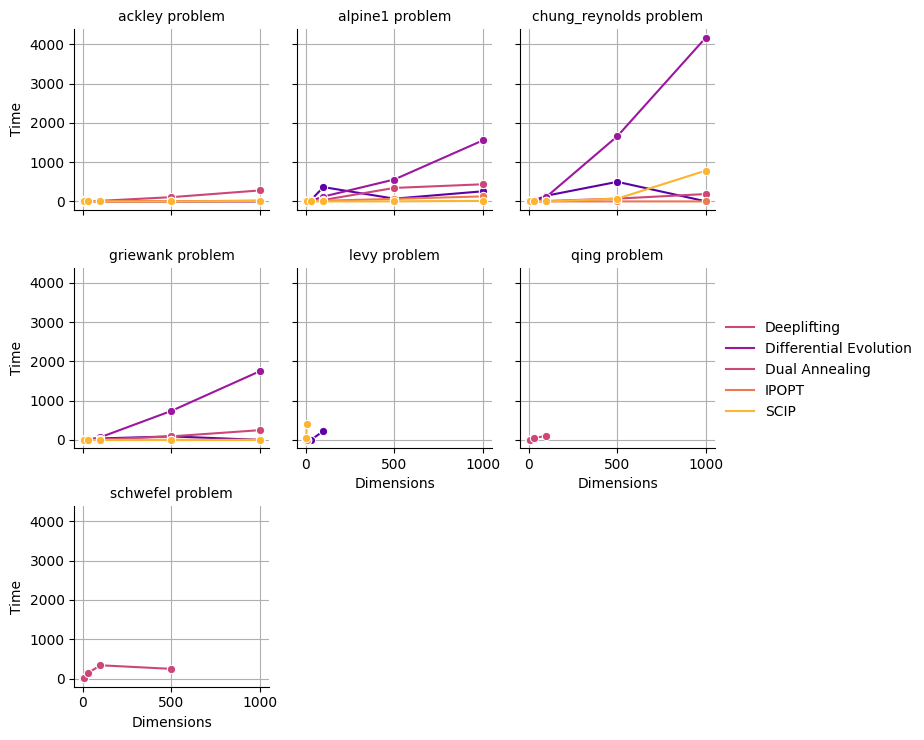

In [28]:
# Create the plot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid
g = sns.FacetGrid(
    results_df, col="problem", col_wrap=3, sharex=True, sharey=True, height=2.5
)

# Map the data to the grid
g.map_dataframe(
    sns.lineplot,
    x='dimensions',
    y='time-mean',
    hue='algorithm',
    palette='plasma',
    marker='o',
)

# Add legends and other aesthetic improvements
g.add_legend()
g.set_axis_labels("Dimensions", "Time")
g.set_titles(col_template="{col_name} problem")

# Add grids for all axes
for ax in g.axes.flatten():
    ax.grid()

# Display the plot
plt.show()

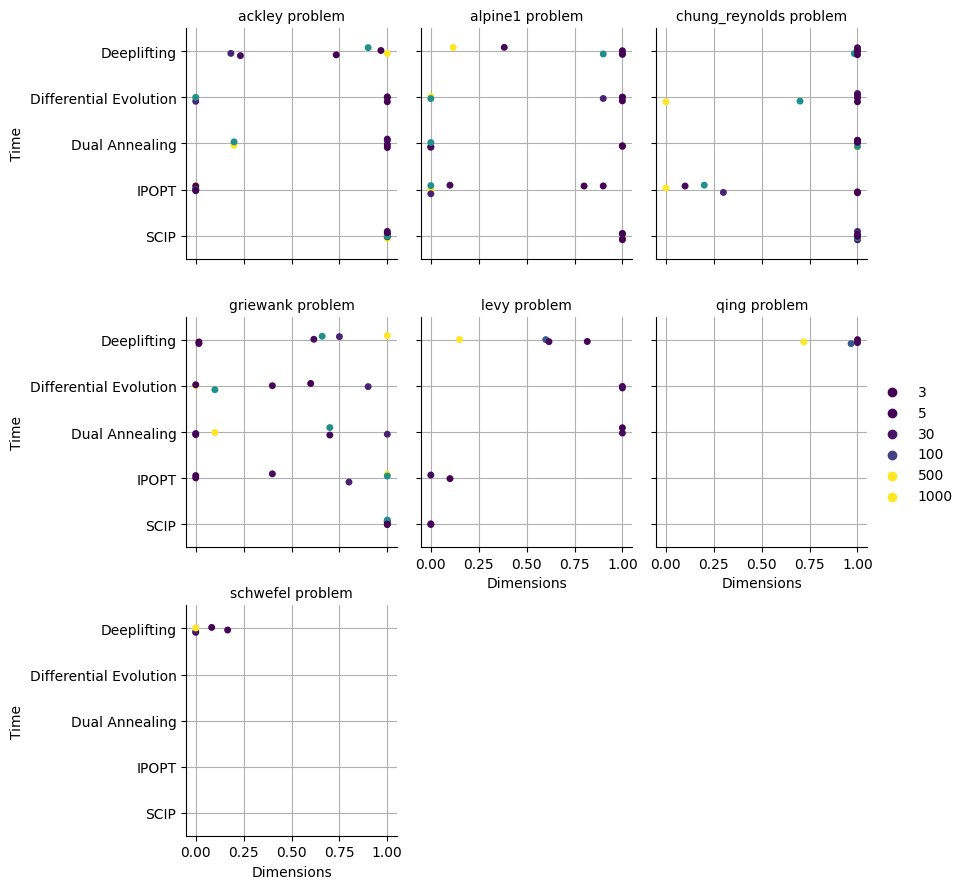

In [25]:
# Create the FacetGrid
g = sns.FacetGrid(
    results_df, col="problem", col_wrap=3, sharex=True, sharey=True, height=3
)

# Map the data to the grid
g.map_dataframe(
    sns.stripplot, x='hits-mean', y='algorithm', hue='dimensions', palette='viridis'
)

# Add legends and other aesthetic improvements
g.add_legend()
g.set_axis_labels("Dimensions", "Time")
g.set_titles(col_template="{col_name} problem")

# Add grids for all axes
for ax in g.axes.flatten():
    ax.grid()